# Prot2GO Data Preprocessing

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.utils import to_undirected, structured_negative_sampling_feasible
from torch_geometric.data import HeteroData

# Define folders
base_dir = Path(Path.cwd())

In [2]:
class ProteinGoDataloader:
    def __init__(self, protein_ids_map, go_ids_map, ppi_folder):
        """
        Initialize the ProteinGODataset class.

        Parameters:
        protein_ids_map (dict): A dictionary mapping protein IDs to their indices.
        go_ids_map (dict): A dictionary mapping GO IDs to their indices.
        ppi_folder (str): The path to the folder containing the species-specific data.

        Attributes:
        protein_ids_map (dict): A dictionary mapping protein IDs to their indices.
        go_ids_map (dict): A dictionary mapping GO IDs to their indices.
        ppi_folder (Path): The path to the folder containing the species-specific data.
        edge_index_protgo_positive (torch.Tensor): A tensor representing the positive edges between proteins and GO terms.
        edge_index_protgo_negative (torch.Tensor): A tensor representing the negative edges between proteins and GO terms.
        associations_positive_df (pandas.DataFrame): A DataFrame containing the positive associations between proteins and GO terms.
        associations_negative_df (pandas.DataFrame): A DataFrame containing the negative associations between proteins and GO terms.
        associations_combined_df (pandas.DataFrame): A DataFrame containing both positive and negative associations between proteins and GO terms.
        hetero_data (torch_geometric.data.HeteroData): A heterogeneous graph data object.
        train_mask (torch.Tensor): A tensor representing the mask for the training set.
        val_mask (torch.Tensor): A tensor representing the mask for the validation set.
        test_mask (torch.Tensor): A tensor representing the mask for the test set.
        train_protein_ids (list): A list of protein IDs for the training set.
        val_protein_ids (list): A list of protein IDs for the validation set.
        test_protein_ids (list): A list of protein IDs for the test set.
        train_go_ids (list): A list of GO IDs for the training set.
        val_go_ids (list): A list of GO IDs for the validation set.
        test_go_ids (list): A list of GO IDs for the test set.
        """
        self.protein_ids_map = protein_ids_map
        self.go_ids_map = go_ids_map
        self.ppi_folder = Path(ppi_folder)
        self.edge_index_protgo_positive = None
        self.edge_index_protgo_negative = None
        self.associations_positive_df = None
        self.associations_negative_df = None
        self.associations_combined_df = None
        self.hetero_data = None
        self.train_mask = None
        self.val_mask = None
        self.test_mask = None
        self.train_protein_ids = None
        self.val_protein_ids = None
        self.test_protein_ids = None
        self.train_go_ids = None
        self.val_go_ids = None
        self.test_go_ids = None

    def convert_associations_to_edge_index(self, associations_df):
        """
        Convert the associations DataFrame into edge indices.

        Parameters:
        associations_df (pandas.DataFrame): A DataFrame containing the associations between proteins and GO terms.

        Returns:
        torch.Tensor: A tensor representing the edge indices for the associations.
        """
        # Map go ids
        associations_df["go_idx"] = associations_df["go_id"].map(self.go_ids_map)

        # Map proteins ids
        associations_df["uniprot_idx"] = associations_df["uniprot_id"].map(
            self.protein_ids_map
        )

        # Save the positive associations
        self.associations_positive_df = associations_df

        # Create edge index
        protein_index = associations_df["uniprot_idx"].values
        go_index = associations_df["go_idx"].values
        indices = np.stack((protein_index, go_index))
        edge_index = torch.tensor(indices, dtype=torch.long)

        self.edge_index_protgo_positive = edge_index
        return edge_index

    def generate_negative_edges(
        self,
        edge_index,
        num_nodes_protein,
        num_nodes_go,
        num_neg_samples,
        weighted=False,
        random_state=42,
        max_attempts_factor=10,
    ):
        """
        Generate negative edges for protein-GO associations.

        Parameters:
        - edge_index (torch.Tensor): The edge index tensor representing existing protein-GO associations.
        - num_nodes_protein (int): The number of protein nodes.
        - num_nodes_go (int): The number of GO nodes.
        - num_neg_samples (int): The number of negative samples to generate.
        - weighted (bool, optional): Whether to use weighted sampling for protein nodes. Default is False.
        - random_state (int, optional): The random seed for reproducibility. Default is 42.
        - max_attempts_factor (int, optional): The maximum number of attempts to generate a valid negative sample. Default is 10.

        Returns:
        torch.Tensor: The tensor representing the generated negative protein-GO associations.
        pandas.DataFrame: The DataFrame containing the generated negative protein-GO associations.
        """
        rng = np.random.default_rng(random_state)
        existing_edges = set(map(tuple, edge_index.t().tolist()))

        if weighted:
            protein_degrees = np.zeros(num_nodes_protein, dtype=int)
            for protein_node, go_node in edge_index.t().tolist():
                protein_degrees[protein_node] += 1

        negative_samples = []
        attempts = 0
        max_attempts = num_neg_samples * max_attempts_factor
        neg_degree_count = np.zeros(num_nodes_protein, dtype=int) if weighted else None

        while len(negative_samples) < num_neg_samples and attempts < max_attempts:
            if weighted:
                protein_node = rng.choice(
                    num_nodes_protein, p=protein_degrees / protein_degrees.sum()
                )
            else:
                protein_node = rng.integers(0, num_nodes_protein)

            go_node = rng.integers(0, num_nodes_go)

            if (protein_node, go_node) not in existing_edges:
                negative_samples.append([protein_node, go_node])
                if weighted:
                    neg_degree_count[protein_node] += 1

            attempts += 1

        neg_sample_tensor = (
            torch.tensor(negative_samples, dtype=torch.long).t()
            if negative_samples
            else torch.empty((2, 0), dtype=torch.long)
        )

        protein_mapping = {v: k for k, v in self.protein_ids_map.items()}
        go_mapping = {v: k for k, v in self.go_ids_map.items()}

        mapped_negative_samples = [
            {
                "uniprot_id": protein_mapping.get(u_idx, None),
                "go_id": go_mapping.get(g_idx, None),
                "uniprot_idx": u_idx,
                "go_idx": g_idx,
            }
            for u_idx, g_idx in negative_samples
        ]

        self.associations_negative_df = pd.DataFrame(mapped_negative_samples)
        self.edge_index_protgo_negative = neg_sample_tensor

        # Ensure no overlap between positive and negative edges
        if not self.check_edge_overlap():
            raise ValueError("Overlap found between positive and negative edges.")

    def combine_associations(self):
        """
        Combine the positive and negative associations DataFrames.

        Returns:
        pandas.DataFrame: A DataFrame containing both positive and negative associations.
        """
        if (
            self.associations_positive_df is None
            or self.associations_negative_df is None
        ):
            raise ValueError(
                "Both positive and negative associations must be generated before combining."
            )

        # Add a label column to differentiate positive and negative associations
        self.associations_positive_df["label"] = 1
        self.associations_negative_df["label"] = 0

        # Combine the DataFrames
        self.associations_combined_df = pd.concat(
            [self.associations_positive_df, self.associations_negative_df],
            ignore_index=True,
        )

        return self.associations_combined_df

    def check_balance(
        self, positive_edge_index, negative_edge_index, num_nodes_protein, num_nodes_go
    ):
        """
        This function checks the degree distribution of proteins and GO terms in the positive and negative edge sets.
        It plots the distributions using KDE plots and saves the plot as a PNG file.

        Parameters:
        - positive_edge_index (torch.Tensor): A tensor representing the edge indices of positive edges.
        - negative_edge_index (torch.Tensor): A tensor representing the edge indices of negative edges.
        - num_nodes_protein (int): The number of protein nodes in the graph.
        - num_nodes_go (int): The number of GO terms in the graph.

        Returns:
        - None. The function only plots and saves the degree distribution plot.
        """
        protein_degrees_pos = np.zeros(num_nodes_protein, dtype=int)
        go_degrees_pos = np.zeros(num_nodes_go, dtype=int)
        for protein_node, go_node in positive_edge_index.t().tolist():
            protein_degrees_pos[protein_node] += 1
            go_degrees_pos[go_node] += 1

        protein_degrees_neg = np.zeros(num_nodes_protein, dtype=int)
        go_degrees_neg = np.zeros(num_nodes_go, dtype=int)
        for protein_node, go_node in negative_edge_index.t().tolist():
            protein_degrees_neg[protein_node] += 1
            go_degrees_neg[go_node] += 1

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.kdeplot(
            protein_degrees_pos, color="blue", label="Positive", fill=True, alpha=0.5
        )
        sns.kdeplot(
            protein_degrees_neg, color="red", label="Negative", fill=True, alpha=0.5
        )
        plt.title("Protein Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Density")
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.kdeplot(
            go_degrees_pos, color="blue", label="Positive", fill=True, alpha=0.5
        )
        sns.kdeplot(go_degrees_neg, color="red", label="Negative", fill=True, alpha=0.5)
        plt.title("GO Terms Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Density")
        plt.legend()

        plt.tight_layout()
        plt.savefig(self.ppi_folder / "balance_check.png", dpi=300)
        plt.show()

    ########################################################################
    def create_heterodata(
        self,
        protein_feats,
        go_feats,
        protein_ids,
        go_ids,
        edge_index_ppi,
        go_edges_df,
        edge_index_protgo_positive,
    ):
        """
        Creates a HeteroData object by combining protein and GO features,
        protein and GO IDs, and protein-protein interaction (PPI) and GO relation edge indices.

        Parameters:
        protein_feats (torch.Tensor): A tensor containing protein features.
        go_feats (torch.Tensor): A tensor containing GO term features.
        protein_ids (list): A list of protein IDs.
        go_ids (list): A list of GO term IDs.
        edge_index_ppi (torch.Tensor): A tensor containing edge indices for PPI.
        go_edges_df (pd.DataFrame): DataFrame containing GO term relationships and edge types.
        edge_index_protgo_positive (torch.Tensor): A tensor containing positive edge indices for protein-GO associations.

        Returns:
        None
        """
        # Make PPI graph undirected
        edge_index_ppi = to_undirected(edge_index_ppi)

        # Concatenate positive and negative edge indices
        edge_index_protgo = torch.cat(
            (edge_index_protgo_positive, self.edge_index_protgo_negative), dim=1
        )

        # Create positive and negative labels
        positive_labels = torch.ones(
            edge_index_protgo_positive.shape[1], dtype=torch.float32
        )
        negative_labels = torch.zeros(
            self.edge_index_protgo_negative.shape[1], dtype=torch.float32
        )
        edge_labels = torch.cat((positive_labels, negative_labels), dim=0)

        # Create a HeteroData object
        hetero_data = HeteroData()
        hetero_data["protein"].x = protein_feats
        hetero_data["go"].x = go_feats
        hetero_data["protein"].id = protein_ids
        hetero_data["go"].id = go_ids
        hetero_data["protein", "ppi", "protein"].edge_index = edge_index_ppi

        # Handle GO edges
        go_ids_map = {go_id: idx for idx, go_id in enumerate(go_ids)}
        relationship_types = go_edges_df["relationship"].unique()

        for relationship in relationship_types:
            edges = go_edges_df[go_edges_df["relationship"] == relationship]
            source_nodes = [go_ids_map[go_id] for go_id in edges["source_go_id"]]
            target_nodes = [go_ids_map[go_id] for go_id in edges["target_go_id"]]
            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
            hetero_data["go", relationship, "go"].edge_index = edge_index

        # Add protein-GO associations
        hetero_data["protein", "associates_with", "go"].edge_index = edge_index_protgo
        hetero_data["protein", "associates_with", "go"].edge_label = edge_labels

        # Assign the HeteroData object to the class attribute
        self.hetero_data = hetero_data

        # Output information about the GO graph structure
        print("Heterogeneous Graph Information:")
        print(f"Number of GO nodes: {hetero_data['go'].x.size(0)}")
        for relationship in relationship_types:
            num_edges = hetero_data["go", relationship, "go"].edge_index.size(1)
            print(f"GO Relationship: {relationship}, Number of edges: {num_edges}")

    def split_dataset(self, train_ratio=0.6):
        """
        Splits the dataset into training, validation, and testing sets based on the given train ratio.

        Parameters:
        train_ratio (float, optional): The ratio of the dataset to be used for training. Default is 0.6.

        Returns:
        None
        """
        val_ratio = (1 - train_ratio) / 2
        test_ratio = val_ratio
        assert isinstance(train_ratio, float), "Train ratio must be a float."
        assert 0 < train_ratio < 1, "Train ratio must be between 0 and 1."

        unique_proteins, edge_positions = torch.unique(
            self.hetero_data["protein", "associates_with", "go"].edge_index[0],
            return_inverse=True,
        )
        permuted_indices = torch.randperm(unique_proteins.size(0))
        num_proteins = unique_proteins.size(0)
        train_end = int(num_proteins * train_ratio)
        val_end = int(num_proteins * (train_ratio + val_ratio))

        train_proteins = permuted_indices[:train_end]
        val_proteins = permuted_indices[train_end:val_end]
        test_proteins = permuted_indices[val_end:]

        train_mask = edge_positions.unsqueeze(0).eq(train_proteins.unsqueeze(1)).any(0)
        val_mask = edge_positions.unsqueeze(0).eq(val_proteins.unsqueeze(1)).any(0)
        test_mask = edge_positions.unsqueeze(0).eq(test_proteins.unsqueeze(1)).any(0)

        self.hetero_data["protein", "associates_with", "go"]["train_mask"] = train_mask
        self.hetero_data["protein", "associates_with", "go"]["val_mask"] = val_mask
        self.hetero_data["protein", "associates_with", "go"]["test_mask"] = test_mask

        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

        protein_mapping = {v: k for k, v in self.protein_ids_map.items()}
        go_mapping = {v: k for k, v in self.go_ids_map.items()}

        self.train_protein_ids = [protein_mapping[idx.item()] for idx in train_proteins]
        self.val_protein_ids = [protein_mapping[idx.item()] for idx in val_proteins]
        self.test_protein_ids = [protein_mapping[idx.item()] for idx in test_proteins]

        train_go_indices = (
            self.hetero_data["protein", "associates_with", "go"]
            .edge_index[1, train_mask]
            .tolist()
        )
        val_go_indices = (
            self.hetero_data["protein", "associates_with", "go"]
            .edge_index[1, val_mask]
            .tolist()
        )
        test_go_indices = (
            self.hetero_data["protein", "associates_with", "go"]
            .edge_index[1, test_mask]
            .tolist()
        )

        self.train_go_ids = [go_mapping[idx] for idx in train_go_indices]
        self.val_go_ids = [go_mapping[idx] for idx in val_go_indices]
        self.test_go_ids = [go_mapping[idx] for idx in test_go_indices]

    def plot_go_edge_type_ratios(self):
        """
        Plots the ratios of different edge types in the GO graph part of the heterodata.
        """
        go_edge_types = []
        edge_counts = []

        for edge_type in self.hetero_data.edge_types:
            if edge_type[0] == "go" and edge_type[2] == "go":
                go_edge_types.append(edge_type[1])
                edge_store = self.hetero_data[edge_type]
                edge_counts.append(edge_store.edge_index.size(1))

        if not go_edge_types:
            print("No GO-GO edges found in the heterodata.")
            return

        total_edges = sum(edge_counts)
        edge_ratios = [count / total_edges for count in edge_counts]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(go_edge_types, edge_ratios)
        plt.title("GO Edge Type Ratios")
        plt.xlabel("Edge Types")
        plt.ylabel("Ratio")
        plt.xticks(rotation=45, ha="right")

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
            )

        # Add total edge count as text
        plt.text(
            0.05, 0.95, f"Total edges: {total_edges}", transform=plt.gca().transAxes
        )

        plt.tight_layout()
        plt.savefig(
            self.ppi_folder / "go_edge_type_ratios.png", dpi=300, bbox_inches="tight"
        )
        plt.close()

        print("GO Edge Type Ratios:")
        for edge_type, ratio, count in zip(go_edge_types, edge_ratios, edge_counts):
            print(f"{edge_type}: {ratio:.2f} ({count} edges)")

    def to_device(self, device):
        """
        Moves the HeteroData object and the masks to the specified device.

        Parameters:
        device (torch.device): The device to move the data to.

        Returns:
        None
        """
        self.hetero_data = self.hetero_data.to(device)
        self.train_mask = self.train_mask.to(device)
        self.val_mask = self.val_mask.to(device)
        self.test_mask = self.test_mask.to(device)

    def create_data_loaders(self, batch_size=32):
        """
        Creates data loaders for training, validation, and testing sets.

        Parameters:
        batch_size (int, optional): The batch size for the data loaders. Default is 32.

        Returns:
        None
        """
        datasets = {}
        masks = {"train": self.train_mask, "val": self.val_mask, "test": self.test_mask}

        for split in masks:
            edge_index = self.hetero_data[
                "protein", "associates_with", "go"
            ].edge_index[:, masks[split]]
            edge_label = self.hetero_data[
                "protein", "associates_with", "go"
            ].edge_label[masks[split]]
            datasets[split] = TensorDataset(edge_index.t(), edge_label)

        self.train_loader = DataLoader(
            datasets["train"], batch_size=batch_size, shuffle=True
        )
        self.val_loader = DataLoader(
            datasets["val"], batch_size=batch_size, shuffle=False
        )
        self.test_loader = DataLoader(
            datasets["test"], batch_size=batch_size, shuffle=False
        )

    def plot_label_ratios(self):
        """
        Plots the label ratios in the training, validation, and testing sets.

        Parameters:
        None

        Returns:
        None
        """
        edge_index = self.hetero_data["protein", "associates_with", "go"].edge_index
        edge_labels = self.hetero_data["protein", "associates_with", "go"].edge_label

        train_labels = edge_labels[self.train_mask]
        val_labels = edge_labels[self.val_mask]
        test_labels = edge_labels[self.test_mask]

        train_label_ratio = torch.sum(train_labels).item() / train_labels.size(0)
        val_label_ratio = torch.sum(val_labels).item() / val_labels.size(0)
        test_label_ratio = torch.sum(test_labels).item() / test_labels.size(0)

        ratios = [train_label_ratio, val_label_ratio, test_label_ratio]
        labels = ["Train", "Val", "Test"]

        plt.figure(figsize=(8, 6))
        bars = plt.bar(labels, ratios, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
        plt.ylabel("Positive Label Ratio")
        plt.title("Positive Label Ratios in Train, Validation, and Test Sets")

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
            )

        # Add total counts as text
        plt.text(
            0.05, 0.95, f"Train: {train_labels.size(0)}", transform=plt.gca().transAxes
        )
        plt.text(
            0.05, 0.90, f"Val: {val_labels.size(0)}", transform=plt.gca().transAxes
        )
        plt.text(
            0.05, 0.85, f"Test: {test_labels.size(0)}", transform=plt.gca().transAxes
        )

        plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
        plt.savefig(self.ppi_folder / "label_ratios.png", dpi=300, bbox_inches="tight")
        plt.close()  # Close the plot to free up memory

        print(f"Train positive ratio: {train_label_ratio:.2f}")
        print(f"Validation positive ratio: {val_label_ratio:.2f}")
        print(f"Test positive ratio: {test_label_ratio:.2f}")

    def save_heterodata(self):
        """
        Saves the HeteroData object to a specified file path.

        Returns:
        None
        """
        save_file_path = self.ppi_folder / "heterodata.pt"
        try:
            torch.save(self.hetero_data, save_file_path)
            print(f"HeteroData object saved to {save_file_path}.")
        except Exception as e:
            print(f"An error occurred while saving the HeteroData object: {e}")

    def check_edge_overlap(self):
        """
        Ensure that there is no overlap between positive and negative edges.

        Returns:
        bool: True if no overlap is found, False otherwise.
        """
        positive_edges_set = set(
            map(tuple, self.edge_index_protgo_positive.t().tolist())
        )
        negative_edges_set = set(
            map(tuple, self.edge_index_protgo_negative.t().tolist())
        )

        # Check for overlap
        overlap = positive_edges_set & negative_edges_set
        if overlap:
            print(f"Found overlap between positive and negative edges: {overlap}")
            return False
        else:
            print("No overlap between positive and negative edges.")
            return True

    def check_data_overlap(self):
        """
        Ensure that there is no leakage of proteins between train, val, and test sets.

        Returns:
        bool: True if no leakage is found, False otherwise.
        """
        train_set = set(self.train_protein_ids)
        val_set = set(self.val_protein_ids)
        test_set = set(self.test_protein_ids)

        # Check for overlaps
        train_val_overlap = train_set & val_set
        train_test_overlap = train_set & test_set
        val_test_overlap = val_set & test_set

        if train_val_overlap or train_test_overlap or val_test_overlap:
            if train_val_overlap:
                print(f"Found overlap between train and val sets: {train_val_overlap}")
            if train_test_overlap:
                print(
                    f"Found overlap between train and test sets: {train_test_overlap}"
                )
            if val_test_overlap:
                print(f"Found overlap between val and test sets: {val_test_overlap}")
            return False
        else:
            print("No leakage of proteins between train, val, and test sets.")
            return True

    def process(
        self,
        associations_df,
        protein_feats,
        go_feats,
        protein_ids,
        go_ids,
        edge_index_ppi,
        go_edges_df,
        train_ratio=0.6,
        ratio=1,
    ):
        """
        Processes the dataset by generating negative edges, creating a HeteroData object,
        splitting the dataset into training, validation, and testing sets, and plotting label ratios.

        Parameters:
        associations_df (pandas.DataFrame): DataFrame containing the associations between proteins and GO terms.
        protein_feats (torch.Tensor): Protein features.
        go_feats (torch.Tensor): GO term features.
        protein_ids (list): Protein IDs.
        go_ids (list): GO term IDs.
        edge_index_ppi (torch.Tensor): Edge indices for protein-protein interactions.
        go_edges_df (pandas.DataFrame): DataFrame containing GO term relationships and edge types.
        train_ratio (float, optional): The ratio of the dataset to be used for training. Default is 0.6.
        ratio (int, optional): The ratio of negative edges to positive edges. Default is 1.

        Returns:
        None
        """
        edge_index_protgo_positive = self.convert_associations_to_edge_index(
            associations_df
        )
        number_pos_edges = edge_index_protgo_positive.shape[1]

        if self.structured_negative_sampling_feasible(edge_index_protgo_positive):
            print(f"Generating {number_pos_edges * ratio} negative edges...")

            self.generate_negative_edges(
                edge_index=edge_index_protgo_positive,
                num_nodes_protein=len(protein_ids),
                num_nodes_go=len(go_ids),
                num_neg_samples=number_pos_edges * ratio,
                weighted=True,
                random_state=42,
            )

            print(
                f"Protein negative associates with GO edge index shape: {self.edge_index_protgo_negative.shape}"
            )
            self.check_balance(
                edge_index_protgo_positive,
                self.edge_index_protgo_negative,
                len(protein_ids),
                len(go_ids),
            )

            self.combine_associations()

            self.create_heterodata(
                protein_feats,
                go_feats,
                protein_ids,
                go_ids,
                edge_index_ppi,
                go_edges_df,
                edge_index_protgo_positive,
            )

            self.split_dataset(train_ratio)

            if not self.check_data_overlap():
                raise ValueError(
                    "Protein leakage detected between train, val, and test sets."
                )

            self.plot_label_ratios()
            self.plot_go_edge_type_ratios()
            self.save_heterodata()

        else:
            print("Negative edges generation isn't feasible.")

    def structured_negative_sampling_feasible(self, edge_index_protgo_positive):
        """
        Checks if structured negative sampling is feasible for the given positive edge indices.

        Parameters:
        edge_index_protgo_positive (torch.Tensor): Edge indices for positive protein-GO associations.

        Returns:
        bool: True if structured negative sampling is feasible, False otherwise.
        """
        return structured_negative_sampling_feasible(edge_index_protgo_positive)

## Load protein-GO associations

In [3]:
# Load protein-GO associations (filtered using PPI dataset)
filepath = base_dir / "data/ppi/associations_human.tsv"
associations_df = pd.read_csv(filepath, sep="\t")

print(f"Protein-GO associations df shape: {associations_df.shape}")
associations_df.head()


Protein-GO associations df shape: (506527, 3)


,EntryID,term,aspect
0,A0A096LP55,GO:0043231,CCO
1,A0A096LP55,GO:0043227,CCO
2,A0A096LP55,GO:0043226,CCO
3,A0A096LP55,GO:0005622,CCO
4,A0A096LP55,GO:0043229,CCO


In [4]:
associations_df["go_id"] = associations_df["term"]
associations_df.drop(columns=["term"], inplace=True)
associations_df["uniprot_id"] = associations_df["EntryID"]
associations_df.drop(columns=["EntryID"], inplace=True)
associations_df

,aspect,go_id,uniprot_id
0,CCO,GO:0043231,A0A096LP55
1,CCO,GO:0043227,A0A096LP55
2,CCO,GO:0043226,A0A096LP55
3,CCO,GO:0005622,A0A096LP55
4,CCO,GO:0043229,A0A096LP55
...,...,...,...
506522,MFO,GO:0005102,Q9Y6Z7
506523,MFO,GO:0005488,Q9Y6Z7
506524,MFO,GO:0140677,Q9Y6Z7
506525,MFO,GO:0030546,Q9Y6Z7


## Load GO embeddings dict

In [5]:
filepath = base_dir / "data/go/go_emb_dict-definition.pkl"
with open(filepath, "rb") as file:
    go_embed_dict = pickle.load(file)
    
# Convert embeddings to tensors
go_feats = torch.stack(
    [torch.tensor(v, dtype=torch.float32) for v in go_embed_dict.values()]
)

# Create mapping dict of GO terms
go_ids = list(go_embed_dict.keys())
go_ids_map = dict(zip(go_ids, range(len(go_ids))))

print(f"GO embeddings dict length: {len(go_embed_dict)}")
print(f"GO term map length: {len(go_ids_map)}")

GO embeddings dict length: 40939
GO term map length: 40939


## Load protein embeddings dict

In [6]:
filepath = base_dir/ "data/ppi/protein_embeddings.pkl"
with open(filepath, "rb") as file:
    protein_embed_dict = pickle.load(file)
    
# Convert embeddings to tensors
protein_feats = torch.stack(
    [torch.tensor(v, dtype=torch.float32) for v in protein_embed_dict.values()]
)
    
# Create mapping dict of GO terms
protein_ids = list(protein_embed_dict.keys())
protein_ids_map = dict(zip(protein_ids, range(len(protein_ids))))

print(f"Protein embeddings dict length: {len(protein_embed_dict)}")
print(f"Protein map length: {len(protein_ids_map)}")

Protein embeddings dict length: 7587
Protein map length: 7587


## Load protein and GO data

In [7]:
protein_data = torch.load(base_dir / "data/ppi/ppi_dataset_train.pt")
go_data = torch.load(base_dir / "data/go/go_data.pt")

print("Protein data:")
print(protein_data)
print("\nGO data:")
print(go_data)

Protein data:
Data(x=[7587, 1024], edge_index=[2, 112150])

GO data:
Data(x=[40939, 768], edge_index=[2, 70984], edge_attr=[70984])


/tmp/ipykernel_13021/3168999632.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  protein_data = torch.load(base_dir / "data/ppi/ppi_dataset_train.pt")
/tmp/ipykernel_1302

In [8]:
# Instantiate ProteinGO dataset class

protgo_dataset = ProteinGoDataloader(
    protein_ids_map=protein_ids_map,
    go_ids_map=go_ids_map,
    ppi_folder=base_dir / "data/ppi",
)

In [9]:
# Load GO multiple edge types
go_edges_df = pd.read_csv(base_dir / "data/go/go_edges.tsv", sep="\t")
go_edges_df


,source_go_id,relationship,target_go_id
0,GO:0000001,is_a,GO:0048308
1,GO:0000001,is_a,GO:0048311
2,GO:0000002,is_a,GO:0007005
3,GO:0000006,is_a,GO:0005385
4,GO:0000007,is_a,GO:0005385
...,...,...,...
70979,GO:2001316,is_a,GO:0120254
70980,GO:2001317,is_a,GO:0034309
70981,GO:2001317,is_a,GO:0042181
70982,GO:2001317,is_a,GO:0120255


In [10]:
# The Model still needs adjustments to process multiple GO edges
# Here we create a go edge file with a single synthetic type "asociates_with"

go_edges_df["relationship"] = "relation"
go_edges_df

,source_go_id,relationship,target_go_id
0,GO:0000001,relation,GO:0048308
1,GO:0000001,relation,GO:0048311
2,GO:0000002,relation,GO:0007005
3,GO:0000006,relation,GO:0005385
4,GO:0000007,relation,GO:0005385
...,...,...,...
70979,GO:2001316,relation,GO:0120254
70980,GO:2001317,relation,GO:0034309
70981,GO:2001317,relation,GO:0042181
70982,GO:2001317,relation,GO:0120255


Generating 1013054 negative edges...
No overlap between positive and negative edges.
Protein negative associates with GO edge index shape: torch.Size([2, 1013054])


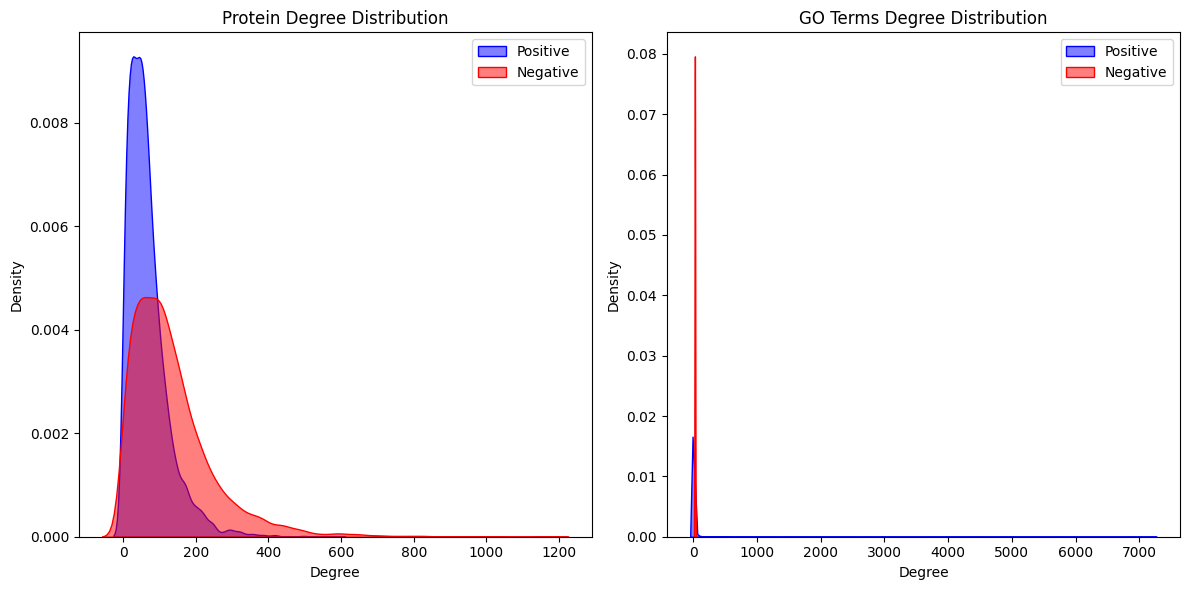

Heterogeneous Graph Information:
Number of GO nodes: 40939
GO Relationship: relation, Number of edges: 70984
No leakage of proteins between train, val, and test sets.
Train positive ratio: 0.33
Validation positive ratio: 0.33
Test positive ratio: 0.33
GO Edge Type Ratios:
relation: 1.00 (70984 edges)
HeteroData object saved to /home/clever/projects/aid2go/data/ppi/heterodata.pt.


In [11]:
# Process object with heterodata and other data structures

protgo_dataset.process(
    associations_df=associations_df,
    protein_feats=protein_data.x,
    go_feats=go_data.x,
    protein_ids=protein_ids,
    go_ids=go_ids,
    edge_index_ppi=protein_data.edge_index,
    go_edges_df=go_edges_df,
    train_ratio=0.6,
    ratio=2,
)

torch.save(protgo_dataset, base_dir / "data/ppi/protgo_dataset.pt")

## Analyze Heterogeneous Network Degrees

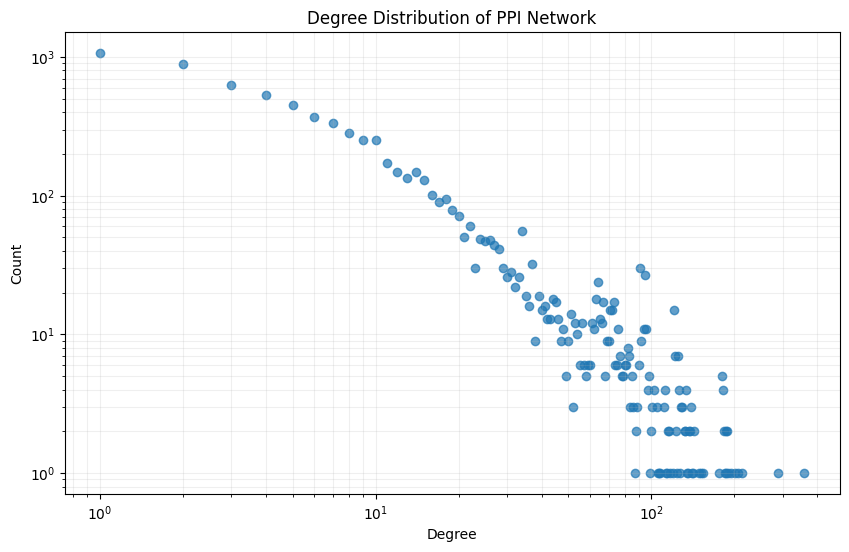

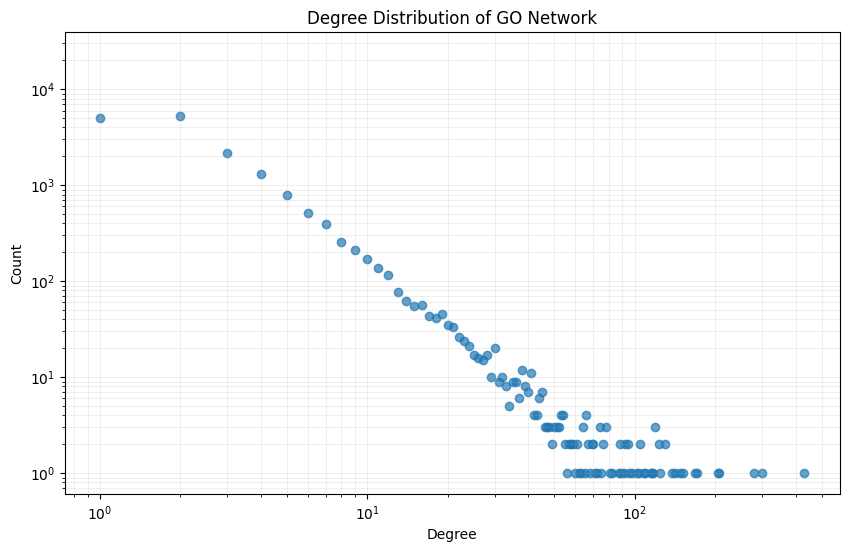

PPI Network Statistics:
Number of nodes: 7587
Number of edges: 112150
Average degree: 14.78

GO Network Statistics:
Number of nodes: 40939
Number of edges: 70984
Average degree: 1.73


In [12]:
def calculate_degree_distribution(edge_index, num_nodes):
    degree = torch.bincount(edge_index[1], minlength=num_nodes)
    unique_degrees, degree_counts = torch.unique(degree, return_counts=True)
    return unique_degrees.numpy(), degree_counts.numpy()


def plot_degree_distribution(degrees, counts, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, counts, alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.title(f"Degree Distribution of {title}")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

data = protgo_dataset.hetero_data

# Calculate and plot degree distribution for PPI network
ppi_degrees, ppi_counts = calculate_degree_distribution(
    data["protein", "ppi", "protein"].edge_index, data["protein"].num_nodes
)
plot_degree_distribution(ppi_degrees, ppi_counts, "PPI Network")

# Calculate and plot degree distribution for GO network
go_degrees, go_counts = calculate_degree_distribution(
    data["go", "relation", "go"].edge_index, data["go"].num_nodes
)
plot_degree_distribution(go_degrees, go_counts, "GO Network")

# Print summary statistics
print("PPI Network Statistics:")
print(f"Number of nodes: {data['protein'].num_nodes}")
print(f"Number of edges: {data['protein', 'ppi', 'protein'].edge_index.shape[1]}")
print(
    f"Average degree: {data['protein', 'ppi', 'protein'].edge_index.shape[1] / data['protein'].num_nodes:.2f}"
)

print("\nGO Network Statistics:")
print(f"Number of nodes: {data['go'].num_nodes}")
print(f"Number of edges: {data['go', 'relation', 'go'].edge_index.shape[1]}")
print(
    f"Average degree: {data['go', 'relation', 'go'].edge_index.shape[1] / data['go'].num_nodes:.2f}"
)